# Building the ML pipeline
Steps:
* Load data and convert to normalized format -> tensor dataset
* 

In [9]:
%load_ext tensorboard

In [9]:
# Path to data folders
root='CrackBinaryClassificationData/'
train_dir = root+'train/'
test_dir = root+'test/'

train_crack_dir = train_dir+'crack/'
train_nocrack_dir = train_dir+'no_crack/'

test_crack_dir = test_dir+'crack/'
test_nocrack_dir = test_dir+'no_crack/'

In [10]:
import os
print('total training crack images:', len(os.listdir(train_crack_dir)))
print('total training no crack images:', len(os.listdir(train_nocrack_dir)))
print('Ratio:', len(os.listdir(train_crack_dir))/(len(os.listdir(train_crack_dir))+len(os.listdir(train_nocrack_dir))))
print('total test crack images:', len(os.listdir(test_crack_dir)))
print('total test no crack images:', len(os.listdir(test_nocrack_dir)))
print('Ratio:', len(os.listdir(test_crack_dir))/(len(os.listdir(test_crack_dir))+len(os.listdir(test_nocrack_dir))))

total training crack images: 602
total training no crack images: 602
Ratio: 0.5
total test crack images: 142
total test no crack images: 142
Ratio: 0.5


In [11]:
import tensorflow as tf

train_ds=tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150,150),
    label_mode='binary',
    batch_size=32,
    color_mode='grayscale',
)

test_ds=tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150,150),
    label_mode='binary',
    batch_size=32,
    color_mode='grayscale',
)

Found 1204 files belonging to 2 classes.
Found 284 files belonging to 2 classes.


In [22]:
# Data augmentation
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        # tf.keras.layers.RandomRotation(0.3, fill_mode='reflect'),
        # tf.keras.layers.RandomTranslation(0.2,0.2, fill_mode='wrap')
    ]
)

augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))


Some data augmentation kind of remove the crack from the image entirely, making it impossible to train properly

In [27]:

model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(150, 150, 1)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
# Adam default learning rate is: 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 150, 150, 1)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 64)       

In [6]:
class_names=train_ds.class_names

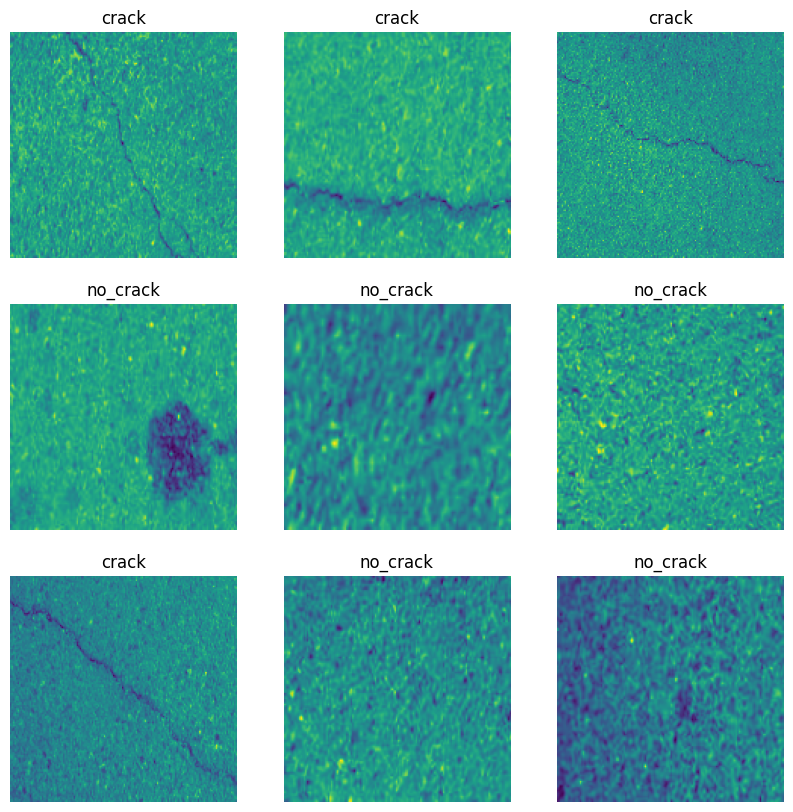

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in augmented_train_ds.take(1):
  l=labels.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(l[i,0])])
    plt.axis("off")


In [32]:
import datetime
log_dir = "crack_binary_keras_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S-2 layer w large dropout")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


model.fit(
  augmented_train_ds,
  validation_data=test_ds,
  epochs=10,
  shuffle=True, 
  callbacks=[tensorboard_callback]
)


Epoch 1/10
38/38 [==============================] - 8s 204ms/step - loss: 0.1929 - accuracy: 0.9277 - val_loss: 0.5355 - val_accuracy: 0.7782
Epoch 2/10
38/38 [==============================] - 8s 204ms/step - loss: 0.1546 - accuracy: 0.9402 - val_loss: 0.5570 - val_accuracy: 0.7641
Epoch 3/10
38/38 [==============================] - 8s 207ms/step - loss: 0.1295 - accuracy: 0.9576 - val_loss: 0.5391 - val_accuracy: 0.7852
Epoch 4/10
38/38 [==============================] - 8s 202ms/step - loss: 0.1030 - accuracy: 0.9701 - val_loss: 0.7128 - val_accuracy: 0.7500
Epoch 5/10
38/38 [==============================] - 8s 205ms/step - loss: 0.1229 - accuracy: 0.9527 - val_loss: 0.7211 - val_accuracy: 0.7218
Epoch 6/10
38/38 [==============================] - 8s 203ms/step - loss: 0.1818 - accuracy: 0.9385 - val_loss: 0.7410 - val_accuracy: 0.7359
Epoch 7/10
38/38 [==============================] - 8s 205ms/step - loss: 0.0796 - accuracy: 0.9751 - val_loss: 0.7441 - val_accuracy: 0.7430
Epoch 

Not too shabby!

In [13]:
%tensorboard --logdir crack_binary_keras_logs/fit/20230302-164435

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-03-02 16:57:17.406767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 16:57:17.512269: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 16:57:17.512287: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-02 16:57:18.061061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvin

In [11]:
import tensorboard
tensorboard.notebook.list()

Known TensorBoard instances:
  - port 6006: logdir crack_binary_keras_logs/fit (started 0:00:18 ago; pid 18234)


In [ ]:
# Save the model, load it and Test it out

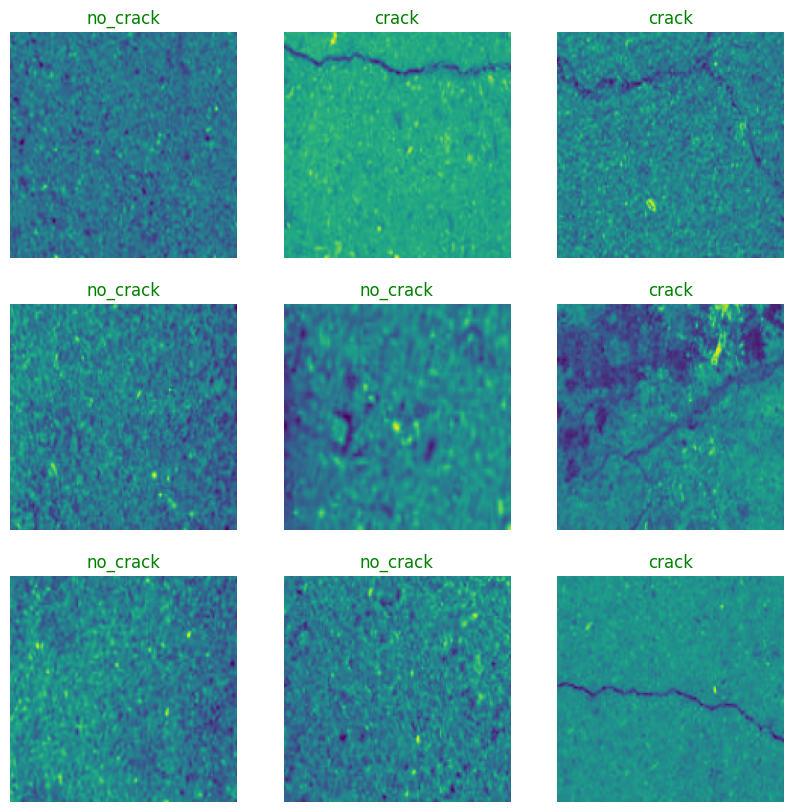

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
  actuals=labels.numpy()
  pred_vals=model(images).numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    act=class_names[int(actuals[i,0])]
    pred=class_names[round(pred_vals[i,0])]
    if act==pred:
      c='green'
    else:
      c='red'
    plt.title(act, fontdict={'color':c})
    plt.axis("off")